# Answering Business Questions using SQL

This project is using the chinook.db to make analysis and answering business questions using SQL.
In this project SQL queries are made, plots are created to visualize the data and conclusions are drawn.

In [1]:
# import the needed packages

import sqlite3 as s3
import pandas as pd
import matplotlib as plt
import numpy as np
%matplotlib inline

In [2]:
#function to connect to the database run the query and give result in a dataframe

def run_query(q):
    with s3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
#function to run a sql command

def run_command(c):
    with s3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
#function to return a list of all tables and views in the database

def show_tables():
    query = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(query)   

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Which genre is the most popular?

In [4]:
# Select the genres (out of Hip-Hop, Punk, Pop and Blues) which sell the most tracks in the USA

query = "SELECT g.name, count(track_id) sells, (count(track_id)*100/(SELECT count(*) FROM track)) percentage FROM track t INNER JOIN genre g on g.genre_id = t.genre_id WHERE g.name IN ('Hip Hop/Rap', 'Alternative & Punk', 'Pop', 'Blues') GROUP BY t.genre_id ORDER BY sells desc;"
run_query(query)

,name,sells,percentage
0,Alternative & Punk,332,9
1,Blues,81,2
2,Pop,48,1
3,Hip Hop/Rap,35,0


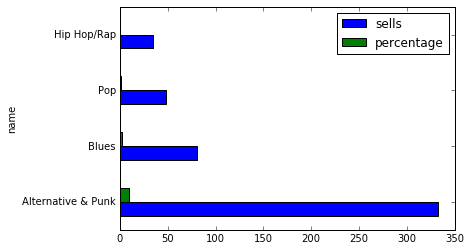

In [5]:
# Plot the table above 

genre_sales_usa = run_query(query)
genre_sales_usa.set_index('name', inplace=True)
genre_sales_usa.plot(kind='barh')

From the plot above it is clear that the most populair genres are Alternative & Punk, Blues and Pop. So it is recommended to add albums of the following artists to the store: Red Tone, Meteor and the Girls and Slim Jim Bites.

## Which sales support agent is performing best

In [6]:
# Calculate the total dollar amount of sales assigned ot each sales support agent
# Join the tables: employee, customer and invoice together, SUM the total invoice amount and Group by employee

query = """ 
    SELECT e.first_name, 
           e.last_name, 
           e.hire_date, 
           SUM(i.total) total_sales 
    FROM employee e 
    INNER JOIN customer c 
    ON c.support_rep_id = e.employee_id 
    INNER JOIN invoice i 
    ON i.customer_id = c.customer_id 
    GROUP BY employee_id
    """
run_query(query)

,first_name,last_name,hire_date,total_sales
0,Jane,Peacock,2017-04-01 00:00:00,1731.51
1,Margaret,Park,2017-05-03 00:00:00,1584.00
2,Steve,Johnson,2017-10-17 00:00:00,1393.92


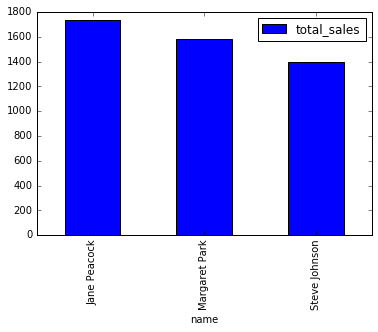

In [7]:
# save the result of the query to a pandas dataframe
# create a new name column which is a combination of first and last name and make that new column the index
# This is resulting in showing the name below the bars

agent_total_sales = run_query(query)
agent_total_sales["name"] = agent_total_sales["first_name"] + " " + agent_total_sales["last_name"]
agent_total_sales.set_index('name', inplace=True)
agent_total_sales.plot(kind='bar')

All sales are assigned to one of the 3 sales support agents belonging to the company. 
There is a difference in the total sales between the sales support agents. An explanation could be the total period they are working for Chinook. The total sales of the sales support agent who started first is highest.

## Analyze customer data for different countries

Below sales data is analyzed for customers from each different country. The following data is calculated:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, these customers are grouped as "Other" in the analysis. The "Other" group ordering is forced to last in the analysis.

In [9]:
q = """\
    SELECT country, 
           number_of_customers, 
           total_sales, 
           average_sales_customer, 
           average_order_value 
    FROM 
        (SELECT n.new_country country, 
                COUNT(DISTINCT(c.customer_id)) number_of_customers, 
                SUM(i.total) total_sales, 
                ROUND(SUM(i.total)/COUNT(DISTINCT(c.customer_id)),2) average_sales_customer, 
                ROUND(SUM(i.total)/COUNT(c.customer_id),2) average_order_value, 
                CASE WHEN n.new_country='Other' 
                    THEN 1 
                    ELSE 0 END as sort 
         FROM customer c 
         INNER JOIN 
             (SELECT a.country, 
              CASE WHEN COUNT(DISTINCT(a.customer_id)) = 1 
                   THEN 'Other' 
                   ELSE a.country END as new_country 
              FROM customer a group by a.country) n 
         ON n.country = c.country 
         INNER JOIN invoice i 
         ON i.customer_id = c.customer_id 
         GROUP BY 1) 
    ORDER BY sort ASC, total_sales DESC  
"""
run_query(q)

,country,number_of_customers,total_sales,average_sales_customer,average_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.57,8.72
9,Other,15,1094.94,73.00,7.45


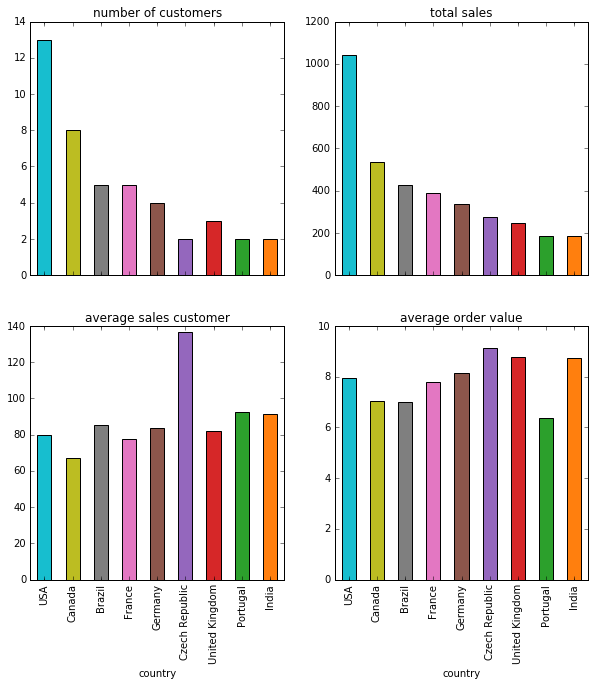

In [10]:
# plot the data from the table above

customer_analysis = run_query(q)
columns = ["USA", "Canada", "Brazil", "France", "Germany", "Czech Republic", "United Kingdom", "Portugal", "India"]
customer_analysis.set_index('country', inplace=True)

fig, axes = plt.pyplot.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True)
customer_analysis.loc[columns,"number_of_customers"].plot(ax=axes[0,0], title="number of customers", kind='bar', color=['#17becf', '#bcbd22', '#7f7f7f', '#e377c2', '#8c564b', '#9467bd', '#d62728', '#2ca02c', '#ff7f0e'])
customer_analysis.loc[columns,"total_sales"].plot(ax=axes[0,1], kind='bar', title="total sales", color=['#17becf', '#bcbd22', '#7f7f7f', '#e377c2', '#8c564b', '#9467bd', '#d62728', '#2ca02c', '#ff7f0e'])
customer_analysis.loc[columns,"average_sales_customer"].plot(ax=axes[1,0], kind='bar', title="average sales customer", color=['#17becf', '#bcbd22', '#7f7f7f', '#e377c2', '#8c564b', '#9467bd', '#d62728', '#2ca02c', '#ff7f0e'])
customer_analysis.loc[columns,"average_order_value"].plot(ax=axes[1,1], kind='bar', title="average order value", color=['#17becf', '#bcbd22', '#7f7f7f', '#e377c2', '#8c564b', '#9467bd', '#d62728', '#2ca02c', '#ff7f0e'])


From the plots above it can be found that the most customers are from the USA. Therefore it is expected that the total sales of the USA is also the hightest. One special figure is the average sales per customer of the Czech Republic. This is must higher than the others. Average order value is almost equal for all countries. One recommendation for the marketing team is: Get more customers to make more sales.

## Album or individual purchase

In [46]:
# Query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics
# - Number of invoices
# - Percentage of invoices

query="""\
SELECT 
   SUM(CASE 
       WHEN (
       SELECT t.track_id FROM album a
       INNER JOIN track t on t.album_id = a.album_id
       WHERE t.album_id = (
           SELECT MAX(album_id) FROM track tr
           INNER JOIN invoice_line il 
           ON il.track_id = tr.track_id
           WHERE invoice_id = inv.invoice_id)
    EXCEPT
        SELECT il.track_id FROM invoice_line il
        INNER JOIN track t on t.track_id = il.track_id
        WHERE il.invoice_id = inv.invoice_id) IS NULL
    
    AND 
        (
        SELECT il.track_id FROM invoice_line il
        INNER JOIN track t on t.track_id = il.track_id
        WHERE il.invoice_id = inv.invoice_id    
    EXCEPT
        SELECT t.track_id FROM album a
        INNER JOIN track t on t.album_id = a.album_id
        WHERE t.album_id = (
           SELECT MAX(album_id) FROM track tr
           INNER JOIN invoice_line il 
           ON il.track_id = tr.track_id
           WHERE invoice_id = inv.invoice_id)) IS NULL
        THEN 1
        ELSE 0
    END) as album_purchase, COUNT(inv.invoice_id) as total_invoices,
    
    CAST( 
      SUM(CASE 
             WHEN (
               SELECT t.track_id FROM album a
               INNER JOIN track t on t.album_id = a.album_id
               WHERE t.album_id = (
                   SELECT MAX(album_id) FROM track tr
                   INNER JOIN invoice_line il 
                   ON il.track_id = tr.track_id
                   WHERE invoice_id = inv.invoice_id)
               EXCEPT
                  SELECT il.track_id FROM invoice_line il
                  INNER JOIN track t on t.track_id = il.track_id
                  WHERE il.invoice_id = inv.invoice_id) IS NULL
    
           AND 
               (
               SELECT il.track_id FROM invoice_line il
               INNER JOIN track t on t.track_id = il.track_id
               WHERE il.invoice_id = inv.invoice_id    
               EXCEPT
               SELECT t.track_id FROM album a
               INNER JOIN track t on t.album_id = a.album_id
               WHERE t.album_id = (
                   SELECT MAX(album_id) FROM track tr
                   INNER JOIN invoice_line il 
                   ON il.track_id = tr.track_id
                   WHERE invoice_id = inv.invoice_id)) IS NULL
           THEN 1
           ELSE 0
           END) AS float)/COUNT(inv.invoice_id) * 100.00 as percentage_invoices
        FROM invoice inv   
"""
run_query(query)

,album_purchase,total_invoices,percentage_invoices
0,114,614,18.566775


In the table above it can be found that 114 out of 614 purchases (18.6%) is an album purchase. From these figures it is recommended to focus more on individual tracks.

## Following steps

Look at the schema and come up with some more business questions, and then write queries to answer them. Here are a few to get you started:

    Which artist is used in the most playlists?
    How many tracks have been purchased vs not purchased?
    Is the range of tracks in the store reflective of their sales popularity?
    Do protected vs non-protected media types have an effect on popularity?
